### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [3]:
aq_datasets = firealarm_processing.get_datasets()

In [4]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

GlobalAttrTitle GlobalAttrSource
0                                  MERRA-2 Global CDH         GES DISC
1                                 MERRA-2 Global PBLH         GES DISC
2                                 MERRA-2 Global TLML         GES DISC
3   MODIS Terra AOD 550 Dark Target Deep Blue Comb...         Giovanni
4   MODIS Terra Aerosol Optical Depth Land Ocean Mean         Giovanni
24         Sentinel-5P TROPOMI Methane CH4 California         GES DISC
25  Sentinel-5P TROPOMI Carbon Monoxide CO California         GES DISC
26    Sentinel-5P TROPOMI Tropospheric NO2 California         GES DISC
27         Sentinel-5P TROPOMI Total Ozone California         GES DISC
28  Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...         GES DISC

### In-situ data inventory

In [5]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

provider      project
0                      AirNow  air_quality
1                      AirNow        AQACF
2          GRIMM-Aethalometer        AQACF
3                   PurpleAir        AQACF
4                     QuantAQ     AQIC-Raw
5                     QuantAQ         AQIC
6                     QuantAQ  AQIC-Hourly
7           PurpleAir-GMU-Cal  air_quality
8  PurpleAir-GMU-Intermediate  air_quality
9    PurpleAir-GMU-Raw-Hourly  air_quality

In [6]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

index   platform               platform_short_name        lat   
0         0  000010102                        St. John's  47.652800  \
1         1  000010401                       Mount Pearl  47.505000   
2         2  000010501               Grand Falls Windsor  49.019400   
3         3  000010601                         Goose Bay  53.304700   
4         4  000010602  MacPherson Avenue - Corner Brook  48.952240   
...     ...        ...                               ...        ...   
3556   7584  TT1010003                         Inchelium  48.296960   
3557   7585  TT5420500              Santa Rosa Rancheria  36.233333   
3558   7590  TT9209004                             Miami  36.922222   
3559   7592  UB1010001                       Ulaanbaatar  47.928385   
3560   7594  UZB010001                          Tashkent  41.367200   

             lon          min_datetime          max_datetime  
0     -52.816700  2018-01-01T00:00:00Z  2022-02-28T00:00:00Z  
1     -52.794700  2018-01-01T00:00:00Z  2022-02-28T00:00:00Z  
2     -55.802800  2018-01-01T00:00:00Z  2021-03-31T00:00:00Z  
3     -60.364400  2018-01-02T00:00:00Z  2024-03-31T00:00:00Z  
4     -57.922070  2020-01-01T00:00:00Z  2022-02-28T00:00:00Z  
...          ...                   ...                   ...  
3556 -118.202420  2018-01-09T00:00:00Z  2019-05-31T00:00:00Z  
3557 -119.765083  2018-01-01T00:00:00Z  2023-08-24T00:00:00Z  
3558  -94.838890  2018-01-01T00:00:00Z  2025-03-18T23:00:00Z  
3559  106.929470  2018-01-01T00:00:00Z  2025-03-04T11:00:00Z  
3560   69.272500  2019-04-01T00:00:00Z  2025-02-25T17:00:00Z  

[3561 rows x 7 columns]

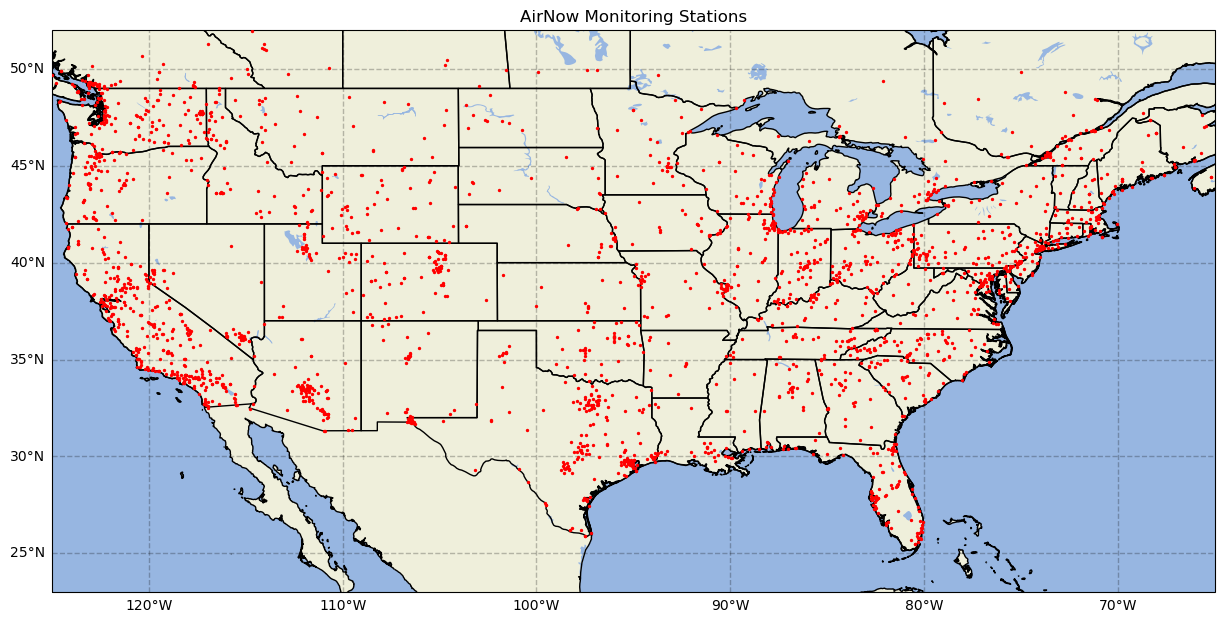

In [7]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# 2025 Palisades and Eaton Fires Impacting Southern California

### Palisades and Eaton Fires MODIS Corrected Reflectance via GIBS

In [8]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'MODIS_Aqua_CorrectedReflectance_TrueColor',
          'Reference_Features',
          'Reference_Labels']
font = ImageFont.truetype('Roboto-Bold.ttf', size=18)
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2025,1,7)
edate = datetime(2025,1,12)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

print(f'Obtaining {len(dates)} days of imagery from GIBS...')

for day in dates[:10]:
    datatime = day.strftime("%Y-%m-%d")
    gibs_wms_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?'
    params = {
        'service': 'WMS',
        'version': '1.3.0',
        'request': 'GetMap',
        'layers': ','.join(layers),
        'styles': '',
        'srs': 'epsg:4326',  # Map projection
        'crs': 'epsg:4326',
        'bbox':','.join(['32','-121','36', '-115']),  # Bounds (min-lat, min-lon, max-lat, max-lon)
        'width': '500',
        'height': '500',
        'time':datatime,  # Time of data
        'format':'image/png',  # Image format
        'transparent':'TRUE',
        'exceptions': 'XML'
    }

    url = f'{gibs_wms_url}{"&".join([f"{k}={v}" for k,v in params.items()])}' 
    response = urlopen(url)
    image = I.open(response)
    draw = ImageDraw.Draw(image)
    draw.text((50, 12), f'MODIS Corrected Reflectance - {datatime}', fill='rgb(0,0,0)', font=font)
    frames.append(image)

Obtaining 5 days of imagery from GIBS...


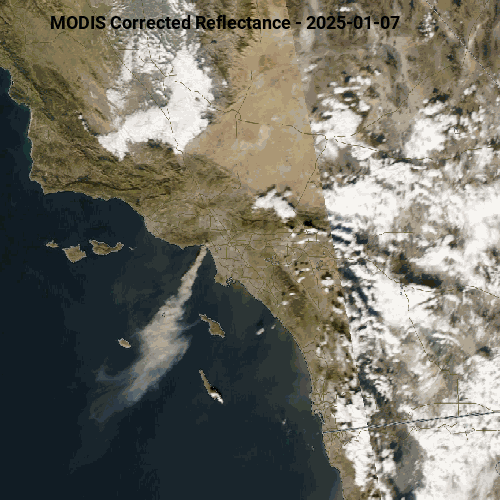

In [9]:
frames[0].save('MODIS.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('MODIS.gif')

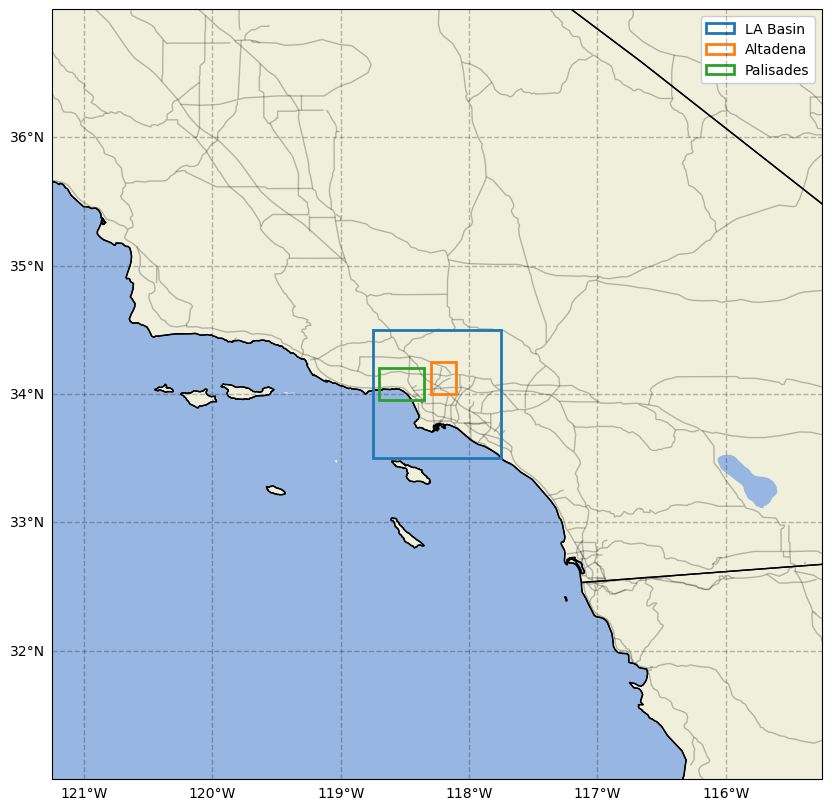

In [10]:
la_basin_fire_bb = {'min_lon': -118.75, 'max_lon': -117.75, 'min_lat': 33.5, 'max_lat': 34.5}
altadena_fire_bb = {'min_lon': -118.3, 'max_lon': -118.1, 'min_lat': 34, 'max_lat': 34.25}
palisades_fire_bb = {'min_lon': -118.7, 'max_lon': -118.35, 'min_lat': 33.95, 'max_lat': 34.2}
la_basin_fire_start = datetime(2025,1,1)
la_basin_fire_end = datetime(2025,1,15)

plotting.map_box([(la_basin_fire_bb, "LA Basin"), (altadena_fire_bb, "Altadena"), (palisades_fire_bb, "Palisades")], padding=2.5)

### TROPOMI CO LA Basin

In [11]:
tropomi_co_2025_la_fires_ts = firealarm_processing.spatial_timeseries('TROPOMI_CO_global', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_co_eaton_altadena_ts = firealarm_processing.spatial_timeseries('TROPOMI_CO_global', altadena_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_co_eaton_palisades_ts = firealarm_processing.spatial_timeseries('TROPOMI_CO_global', palisades_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CO_global&minLon=-118.75&minLat=33.5&maxLon=-117.75&maxLat=34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 10.689782500034198 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CO_global&minLon=-118.3&minLat=34&maxLon=-118.1&maxLat=34.25&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 1.8118643341585994 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CO_global&minLon=-118.7&minLat=33.95&maxLon=-118.35&maxLat=34.2&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.3152945840265602 seconds


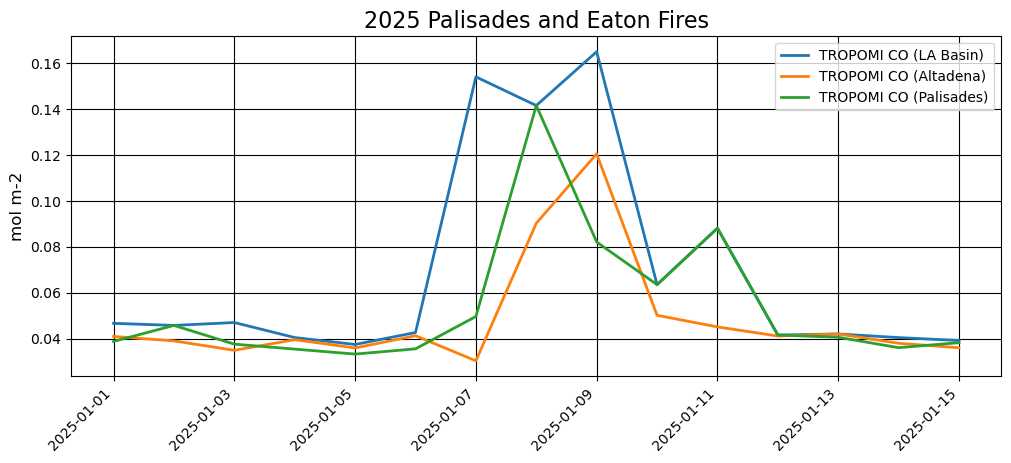

In [12]:
plotting.timeseries_plot([(tropomi_co_2025_la_fires_ts['maximum'], 'TROPOMI CO (LA Basin)'), 
                          (tropomi_co_eaton_altadena_ts['maximum'], 'TROPOMI CO (Altadena)'),
                          (tropomi_co_eaton_palisades_ts['maximum'], 'TROPOMI CO (Palisades)')],
                         '', 'mol m-2', '2025 Palisades and Eaton Fires', norm=False)


In [13]:
tropomi_co_la_2025_avg = firealarm_processing.temporal_mean('TROPOMI_CO_global', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 36}, datetime(2025,1,7), datetime(2025,1,9))

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TROPOMI_CO_global&b=-121%2C31%2C-116%2C36&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 1.4388445001095533 seconds


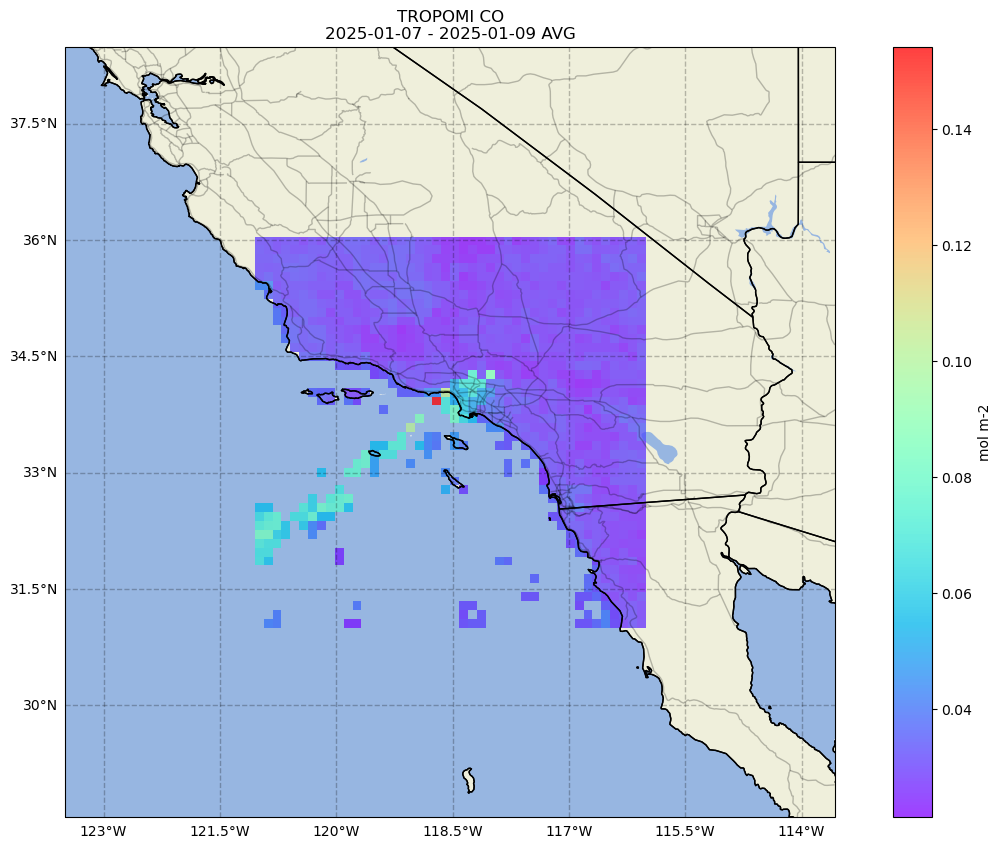

In [14]:
plotting.map_data(tropomi_co_la_2025_avg, f'TROPOMI CO\n2025-01-07 - 2025-01-09 AVG', cb_label='mol m-2')

In [15]:
tropomi_no2_2025_la_fires_ts = firealarm_processing.spatial_timeseries('TROPOMI_NO2_global', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_no2_eaton_altadena_ts = firealarm_processing.spatial_timeseries('TROPOMI_NO2_global', altadena_fire_bb, la_basin_fire_start, la_basin_fire_end)
tropomi_no2_eaton_palisades_ts = firealarm_processing.spatial_timeseries('TROPOMI_NO2_global', palisades_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_NO2_global&minLon=-118.75&minLat=33.5&maxLon=-117.75&maxLat=34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.2573851658962667 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_NO2_global&minLon=-118.3&minLat=34&maxLon=-118.1&maxLat=34.25&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.3022625830490142 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_NO2_global&minLon=-118.7&minLat=33.95&maxLon=-118.35&maxLat=34.2&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.41947770793922246 seconds


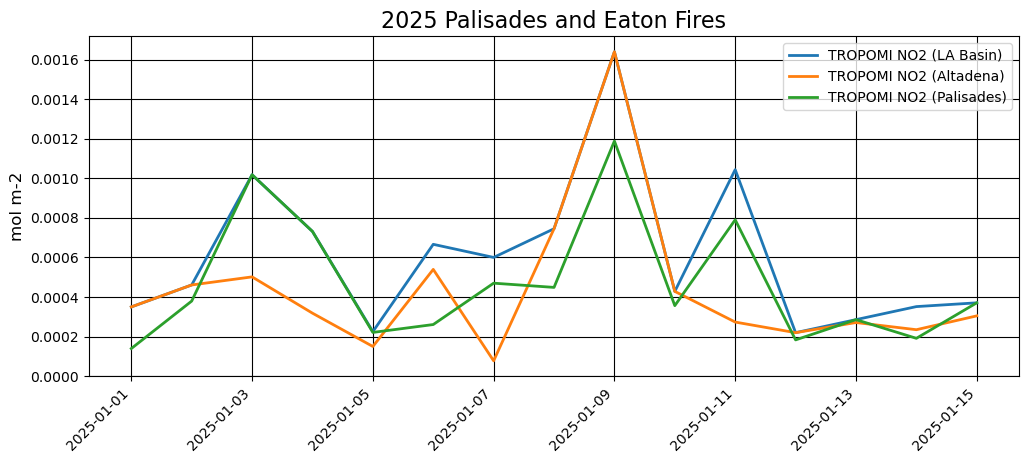

In [16]:
plotting.timeseries_plot([(tropomi_no2_2025_la_fires_ts['maximum'], 'TROPOMI NO2 (LA Basin)'), 
                          (tropomi_no2_eaton_altadena_ts['maximum'], 'TROPOMI NO2 (Altadena)'),
                          (tropomi_no2_eaton_palisades_ts['maximum'], 'TROPOMI NO2 (Palisades)')],
                         '', 'mol m-2', '2025 Palisades and Eaton Fires', norm=False)


In [17]:
tropomi_no2_la_2025_avg = firealarm_processing.temporal_mean('TROPOMI_NO2_global', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 36}, datetime(2025,1,7), datetime(2025,1,9))

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TROPOMI_NO2_global&b=-121%2C31%2C-116%2C36&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 0.5570254998747259 seconds


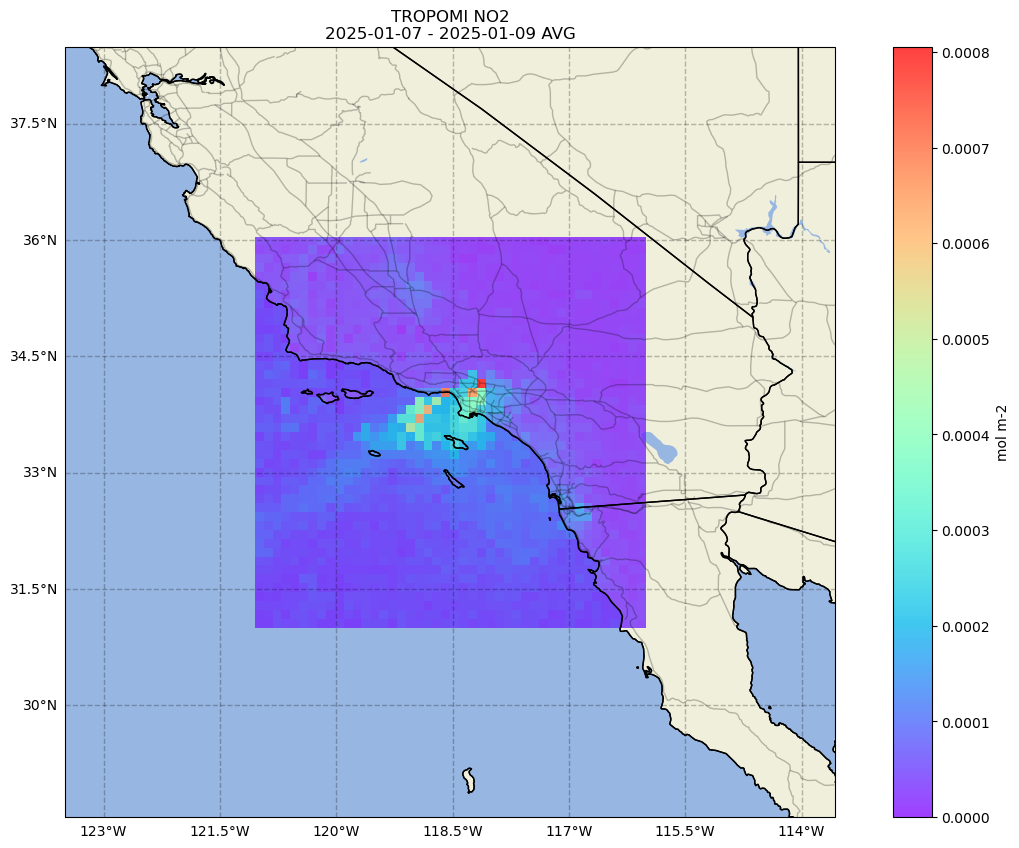

In [18]:
plotting.map_data(tropomi_no2_la_2025_avg, f'TROPOMI NO2\n2025-01-07 - 2025-01-09 AVG', cb_label="mol m-2")


### In Situ Observations

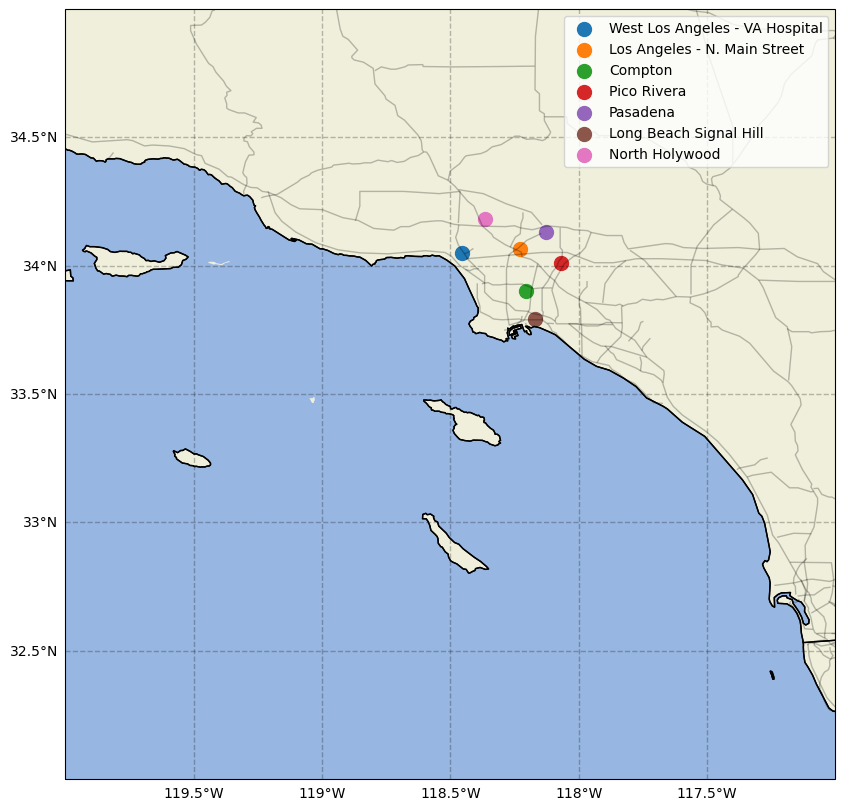

In [19]:
# We will subset the list of AirNow monitoring sites and use them to query for in situ data

sites_of_interest = [
    'Compton',
    'Long Beach Signal Hill',
    'Los Angeles - N. Main Street',
    'North Holywood',
    'Pasadena',
    'Pico Rivera',
    'West Los Angeles - VA Hospital'
]

# Subset to sites within the greater Los Angeles region
la_sites = airnow_sites[(airnow_sites['lat']>33.5) & (airnow_sites['lat']< 34.5) & (airnow_sites['lon']>-118.75) & (airnow_sites['lon']< -117.75)]

# Further subset to sites of interest
la_sites_of_interest = la_sites[la_sites["platform_short_name"].isin(sites_of_interest)]

# Plot a map of site locations
formatted_la_sites_of_interest = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in la_sites_of_interest.iterrows()]
plotting.map_points(formatted_la_sites_of_interest, region='la', legend=True)

#### Query In Situ Service

In [20]:
la_fire_airnow_insitu = None
for index, site in la_sites_of_interest.iterrows():
    print(f'Querying for data at {site["platform_short_name"]}')
    site_id = site["platform"]
    if site_id.startswith("0"):
        site_id = site_id[1:]
    if la_fire_airnow_insitu is None:
        la_fire_airnow_insitu = firealarm_processing.insitu('AirNow', 'air_quality', '-118.75,33.5,-117.75,34.25', datetime(2025,1,3), datetime(2025,1,15), platform=site_id)
    else:
        query_results = firealarm_processing.insitu('AirNow', 'air_quality', '-118.75,33.5,-117.75,34.25', datetime(2025,1,3), datetime(2025,1,15), platform=site_id)
        la_fire_airnow_insitu = pd.concat([la_fire_airnow_insitu, query_results])

Querying for data at West Los Angeles - VA Hospital
https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=AirNow&project=air_quality&startTime=2025-01-03T00:00:00Z&endTime=2025-01-15T00:00:00Z&bbox=-118.75,33.5,-117.75,34.25&platform=60370113
Querying for data at Los Angeles - N. Main Street
https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=AirNow&project=air_quality&startTime=2025-01-03T00:00:00Z&endTime=2025-01-15T00:00:00Z&bbox=-118.75,33.5,-117.75,34.25&platform=60371103
Querying for data at Compton
https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=AirNow&project=air_quality&startTime=2025-01-03T00:00:00Z&endTime=2025-01-15T00:00:00Z&bbox=-118.75,33.5,-117.75,34.25&platform=60371302
Querying for data at Pico Rivera
https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/

In [21]:
# Query for QuantAQ In Situ data
la_fire_quant_aq_insitu = firealarm_processing.insitu('QuantAQ', 'AQIC-Hourly', '-118.75,33.5,-117.75,34.5', datetime(2025,1,3), datetime(2025,1,15))

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=QuantAQ&project=AQIC-Hourly&startTime=2025-01-03T00:00:00Z&endTime=2025-01-15T00:00:00Z&bbox=-118.75,33.5,-117.75,34.5


## In-situ PM2.5

In [22]:
prepped_pm25_results = []
prepped_pm25_results.append((la_fire_quant_aq_insitu, 'pm2_5', f'QuantAQ: JPL Building 301'))

for name, group in la_fire_airnow_insitu.groupby("short_name"):
    if not all(np.isnan(group["pm2_5"])) and group["pm2_5"].max() > 70:
        prepped_pm25_results.append((group, 'pm2_5', f'AirNow: {name}'))
        

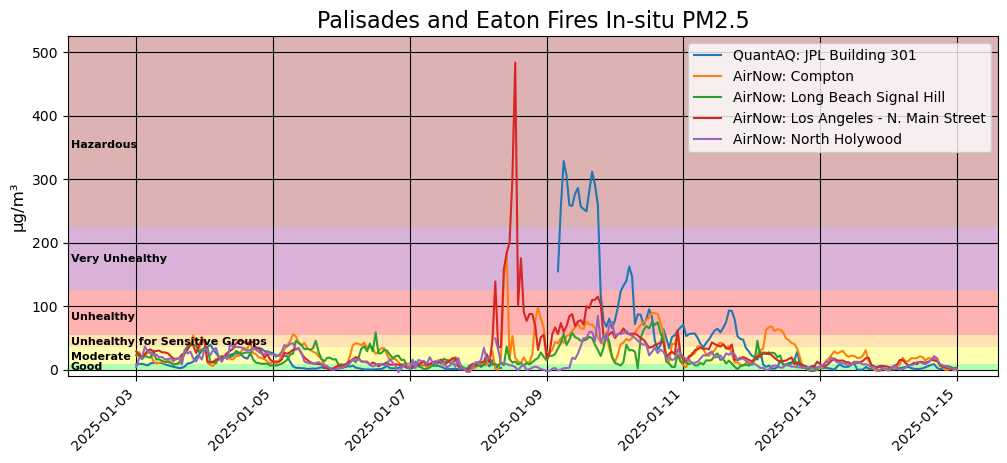

In [24]:
plotting.plot_la_fires_pm25_insitu(prepped_pm25_results, 'Palisades and Eaton Fires In-situ PM2.5', 'µg/m³')


### In-situ Carbon Monoxide

In [25]:
prepped_co_results = []

for name, group in la_fire_airnow_insitu.groupby("short_name"):
    if not all(np.isnan(group["co"])) and group["co"].max() > 2:
        prepped_co_results.append((group, 'co', f'AirNow: {name}'))

# Convert QuantAQ CO data from ppb to ppm to align with 
la_fire_quant_aq_insitu['co_ppm'] = la_fire_quant_aq_insitu['co'] / 1000

prepped_co_results.append((la_fire_quant_aq_insitu, 'co_ppm', f'QuantAQ: JPL Building 301'))

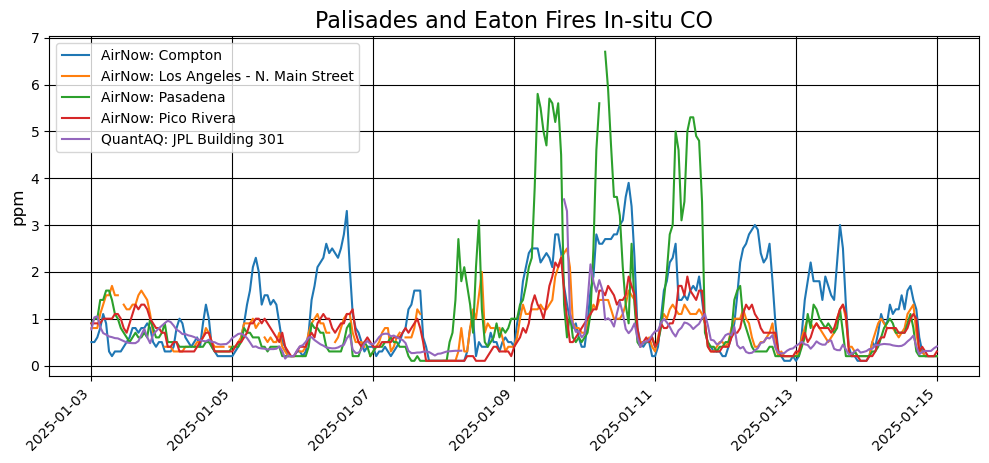

In [26]:
plotting.plot_insitu(prepped_co_results, 'Palisades and Eaton Fires In-situ CO', 'ppm')


### In-situ NO

In [27]:
prepped_no_results = []

for name, group in la_fire_airnow_insitu.groupby("short_name"):
    if not all(np.isnan(group["no"])):
        prepped_no_results.append((group, 'no', f'AirNow: {name}'))

prepped_no_results.append((la_fire_quant_aq_insitu, 'no', f'QuantAQ: JPL Building 301'))

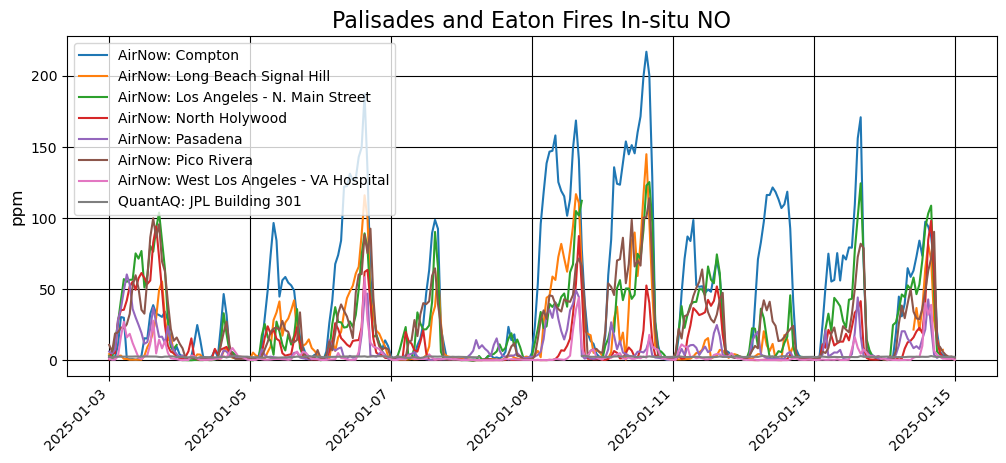

In [28]:
plotting.plot_insitu(prepped_no_results, 'Palisades and Eaton Fires In-situ NO', 'ppm')


### VIIRS Aerosol Optical Thickness

In [29]:
viirs_la_2025_daily_diff = firealarm_processing.daily_diff('laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean', 'laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean_clim', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/dailydifferenceaverage_spark?dataset=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean&climatology=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean_clim&b=-118.75%2C33.5%2C-117.75%2C34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z

Waiting for response from FireAlarm... took 14.80989491706714 seconds


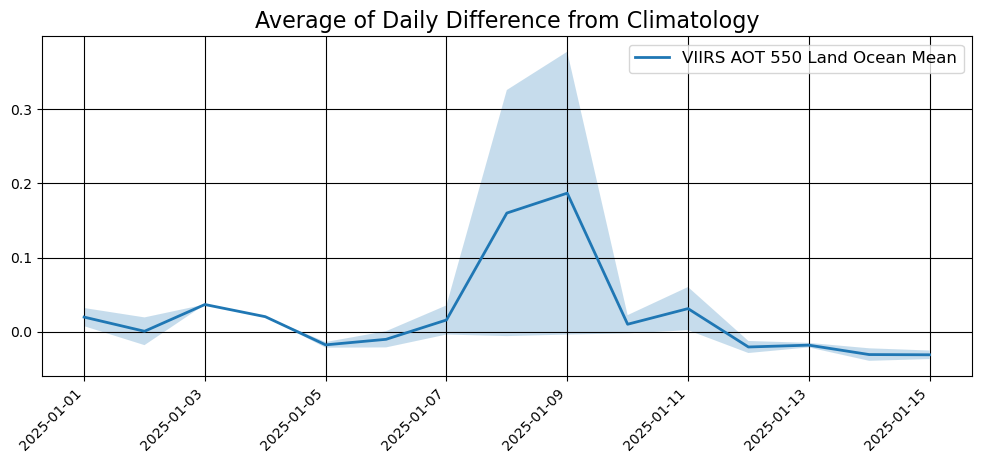

In [30]:
plotting.timeseries_bands_plot(viirs_la_2025_daily_diff, 'VIIRS AOT 550 Land Ocean Mean', '', '', f'Average of Daily Difference from Climatology')

### TEMPO - NO2, Ozone, Formaldehyde

In [31]:
tempo_no2_ts = firealarm_processing.spatial_timeseries('TEMPO_NO2_L3_V03', la_basin_fire_bb, la_basin_fire_start, la_basin_fire_end)
tempo_o3_ts = firealarm_processing.spatial_timeseries('TEMPO_O3TOT_L3_V03', altadena_fire_bb, la_basin_fire_start, la_basin_fire_end)
tempo_hcho_ts = firealarm_processing.spatial_timeseries('TEMPO_HCHO_L3_V03', palisades_fire_bb, la_basin_fire_start, la_basin_fire_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TEMPO_NO2_L3_V03&minLon=-118.75&minLat=33.5&maxLon=-117.75&maxLat=34.5&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 7.432951958151534 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TEMPO_O3TOT_L3_V03&minLon=-118.3&minLat=34&maxLon=-118.1&maxLat=34.25&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.483267999952659 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TEMPO_HCHO_L3_V03&minLon=-118.7&minLat=33.95&maxLon=-118.35&maxLat=34.2&startTime=2025-01-01T00%3A00%3A00Z&endTime=2025-01-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.38616462517529726 seconds


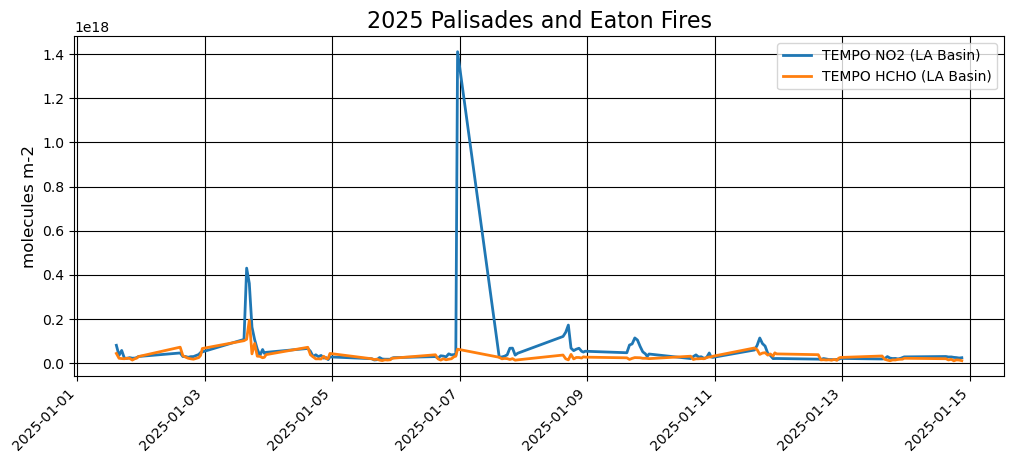

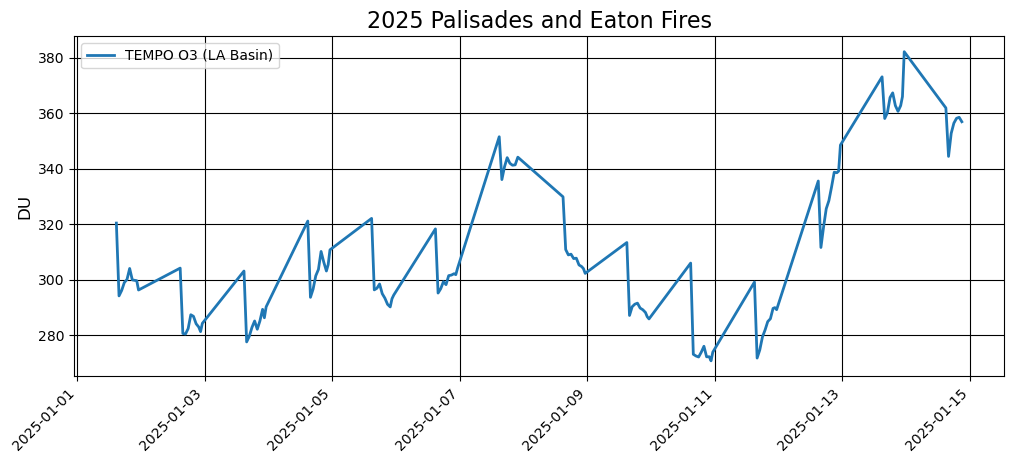

In [32]:
plotting.timeseries_plot([(tempo_no2_ts['maximum'], 'TEMPO NO2 (LA Basin)'), 
                          (tempo_hcho_ts['maximum'], 'TEMPO HCHO (LA Basin)')],
                         '', 'molecules m-2', '2025 Palisades and Eaton Fires', norm=False)
plotting.timeseries_plot([(tempo_o3_ts['maximum'], 'TEMPO O3 (LA Basin)')],
                         '', 'DU', '2025 Palisades and Eaton Fires', norm=False)


In [33]:
tempo_no2_la_2025_avg = firealarm_processing.temporal_mean('TEMPO_NO2_L3_V03', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 35}, datetime(2025,1,7), datetime(2025,1,9))
tempo_o3_la_2025_avg = firealarm_processing.temporal_mean('TEMPO_O3TOT_L3_V03', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 35}, datetime(2025,1,7), datetime(2025,1,9))
tempo_hcho_la_2025_avg = firealarm_processing.temporal_mean('TEMPO_HCHO_L3_V03', {'min_lon': -121, 'max_lon': -116, 'min_lat': 31, 'max_lat': 35}, datetime(2025,1,7), datetime(2025,1,9))

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TEMPO_NO2_L3_V03&b=-121%2C31%2C-116%2C35&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 1.8843426250386983 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TEMPO_O3TOT_L3_V03&b=-121%2C31%2C-116%2C35&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 1.8888128749094903 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TEMPO_HCHO_L3_V03&b=-121%2C31%2C-116%2C35&startTime=2025-01-07T00%3A00%3A00Z&endTime=2025-01-09T00%3A00%3A00Z

Waiting for response from FireAlarm... took 2.0968689578585327 seconds


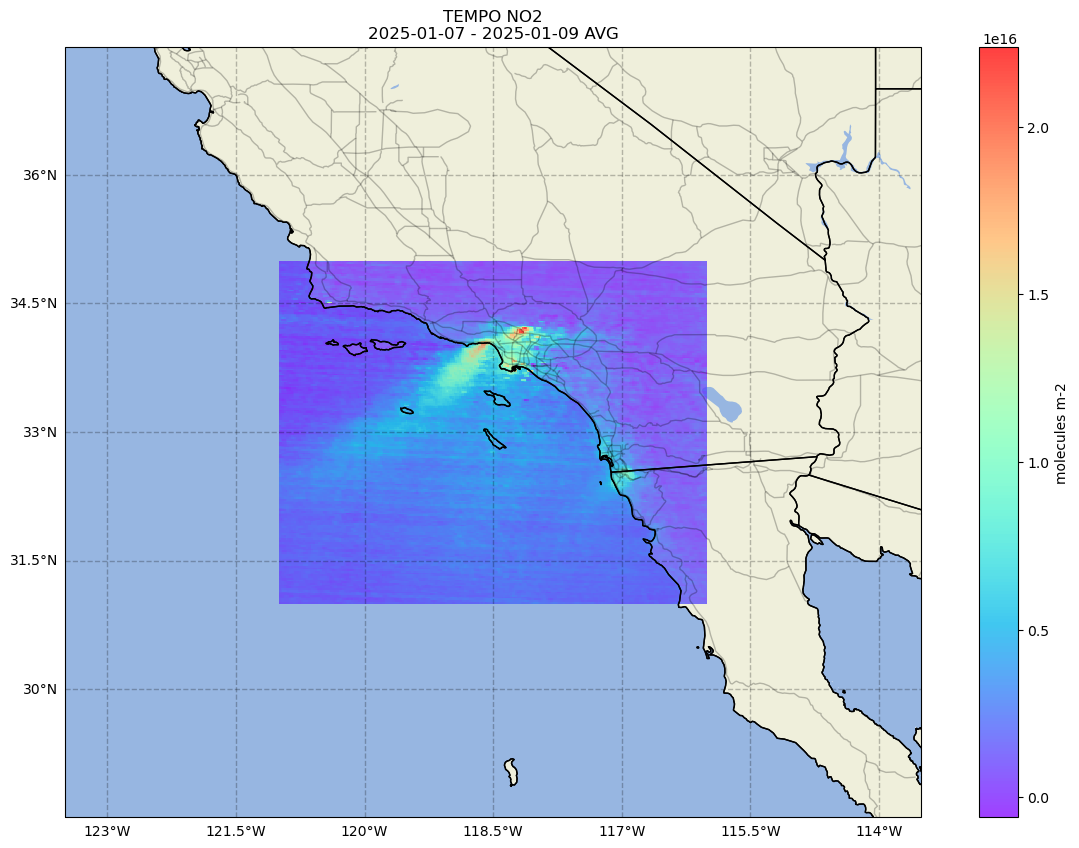

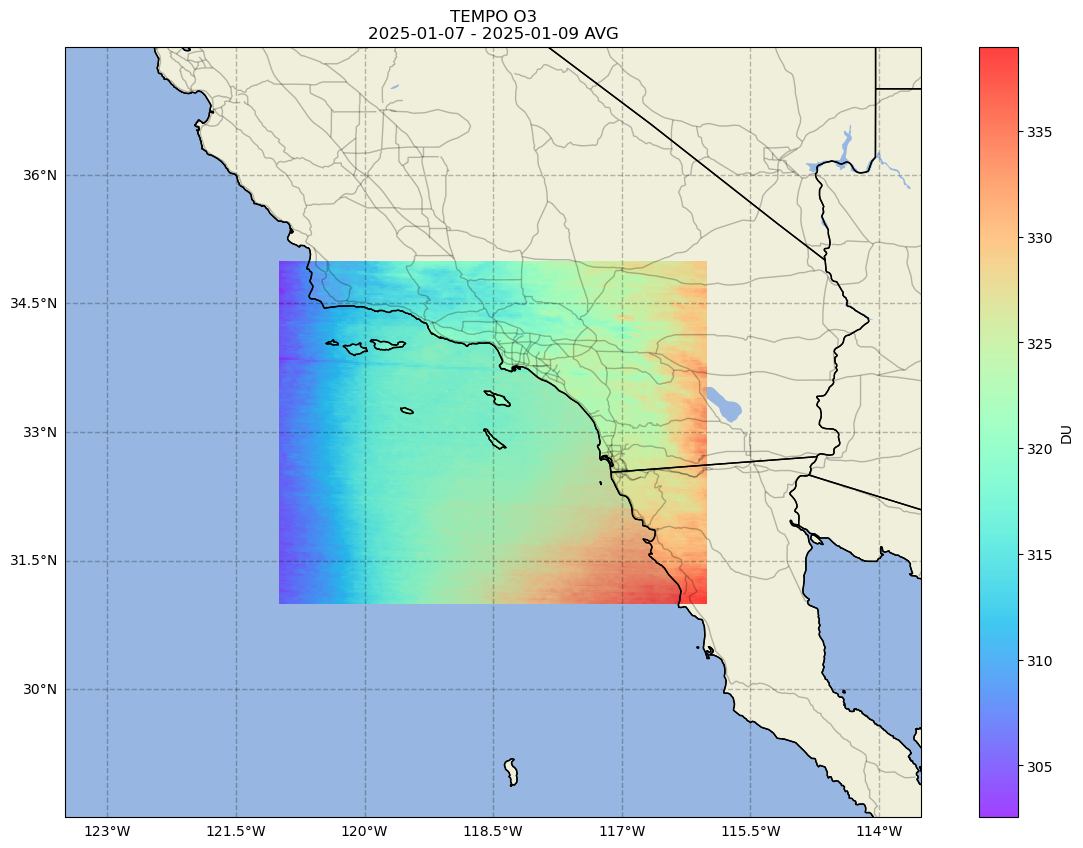

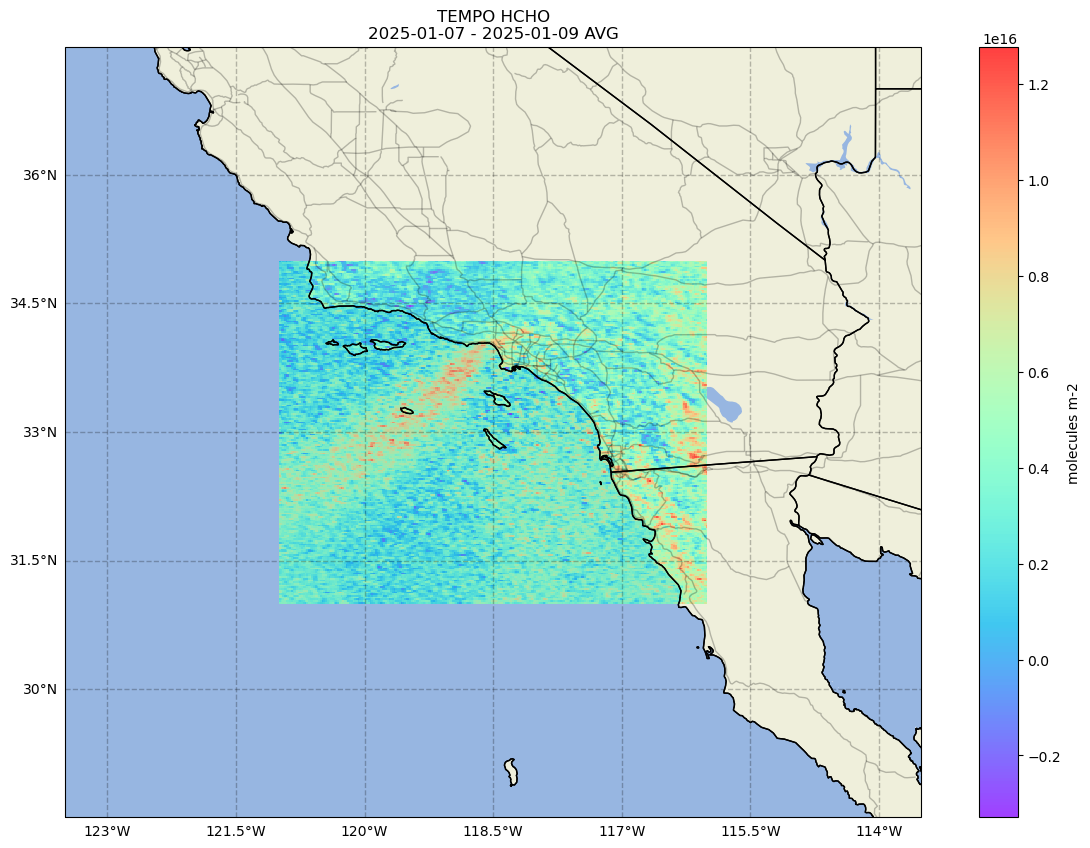

In [34]:
plotting.map_data(tempo_no2_la_2025_avg, f'TEMPO NO2\n2025-01-07 - 2025-01-09 AVG', cb_label='molecules m-2')
plotting.map_data(tempo_o3_la_2025_avg, f'TEMPO O3\n2025-01-07 - 2025-01-09 AVG', cb_label='DU')
plotting.map_data(tempo_hcho_la_2025_avg, f'TEMPO HCHO\n2025-01-07 - 2025-01-09 AVG', cb_label='molecules m-2')